In [1]:
from ipywidgets import interactive

from PIL import Image as im

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal as sg
from scipy.ndimage import filters, measurements, morphology, gaussian_laplace

from skimage.morphology import skeletonize, remove_small_objects, convex_hull_image
from skimage.measure import label, regionprops


import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import load_img, show_img, show_hist, resize_img, save_img, normalize
from lib.edge_lib import threshold, get_points, overlay_points
from lib.crop_lib import mark_region, fit_lines, find_intersections, warp_to_corners

# Input image

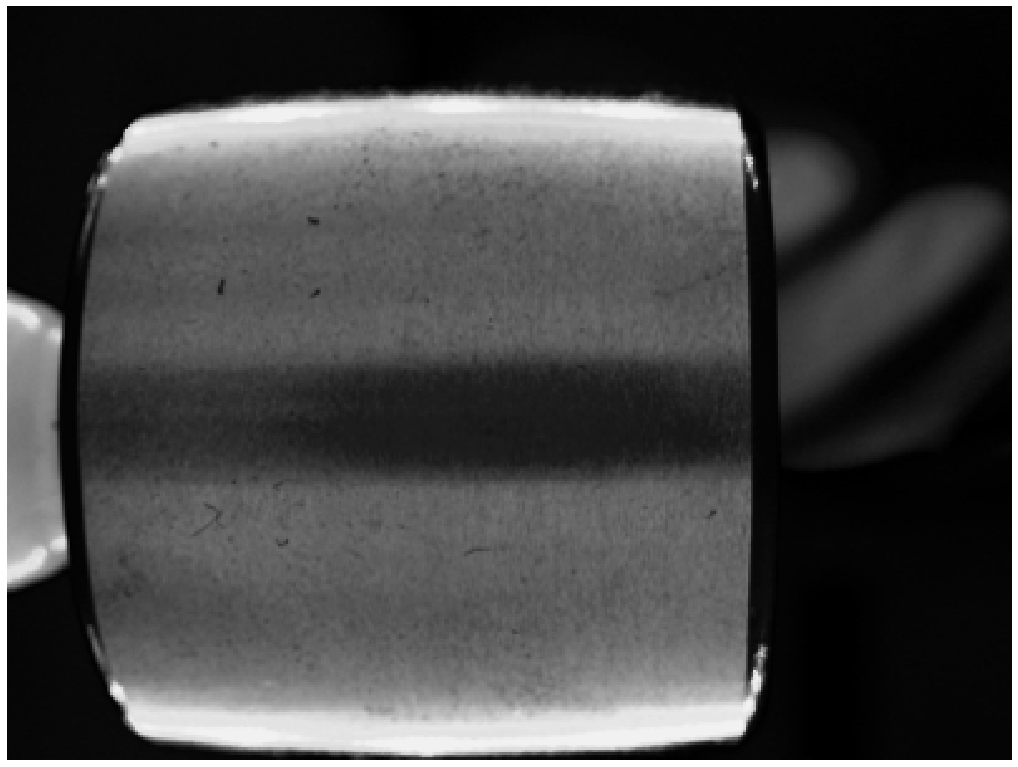

(300, 400)


In [15]:
img = load_img("c02.jpg", size=(300, 400)) 
show_img(img, color="bw", size=(18,18))

print(img.shape)
height, width = img.shape
size= height*width

# Cropped Image

((52.39600725909468, 81.16232464929851), (50.87347960042108, 254.65741788717975), (270.2617067933965, 81.16232464929851), (271.7502117032126, 250.78045712943782))


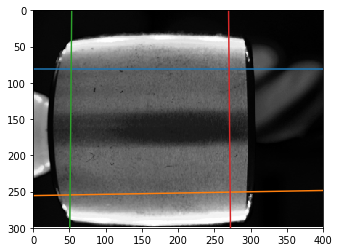

In [16]:
border, scale = mark_region(img)
line_points = fit_lines(border, scale)
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")

for p1, p2 in line_points:
    x, y = zip(p1, p2)
    plt.plot(x, y, "-")
    
ax.set_xlim((0, width))
ax.set_ylim((height, 0))

intersections = find_intersections(line_points, img.shape)
print(intersections)

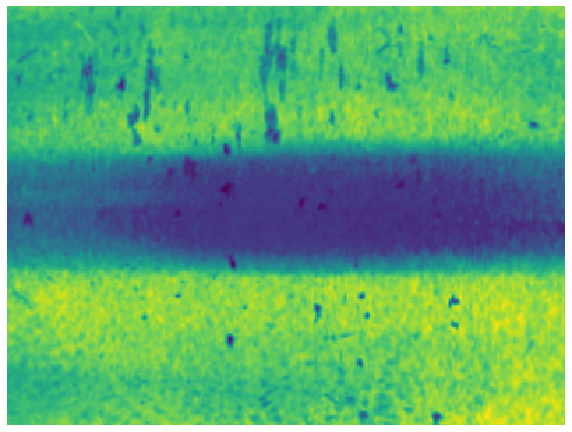

In [4]:
warped = warp_to_corners(img, *intersections)
show_img(warped, size=(10,10))

In [17]:
img = warped

# Sobel edge detection

In [18]:
def sobel(img, vert_weight=1, horr_weight=1):
    # Vertical Edges
    vert_edges = np.zeros(img.shape)
    filters.sobel(img, 1, vert_edges)
    
    # Horizontal Edges
    horr_edges = np.zeros(img.shape)
    filters.sobel(img, 0, horr_edges)
    
    # Magnitude
    magnitude = np.sqrt(vert_weight*vert_edges**2 + horr_weight*horr_edges**2)    
    
    return magnitude

In [19]:
 def laplace(img):
    kernel = np.array([[0,1,0],
                 [1,-4,1],
                 [0,1,0]])
    lapl_img = sg.convolve(kernel, img, 'valid')
    lapl_img = normalize(lapl_img)
    
    return lapl_img

In [20]:
def derivative(img, sigma=0.5, order=1):
        vert_edges = np.zeros(img.shape)
        filters.gaussian_filter(img, (sigma, sigma), (0,order), vert_edges)

        horr_edges = np.zeros(img.shape)
        filters.gaussian_filter(img, (sigma, sigma), (order,0), horr_edges)
        
        magnitude = np.sqrt(vert_edges**2+horr_edges**2)
        
        return magnitude

In [21]:
def detect_edges(method, vert_weight=1, horr_weight=0.6 ,sigma=0.2, order=1):
    if method == "sobel":
        response_img = sobel(img, vert_weight, horr_weight)
    
    elif method == "laplace":
        response_img = laplace(img)
        
    elif method == "derivative":
        response_img = derivative(img, sigma, order)
        
    print(np.max(response_img))
    show_img(response_img)
    
    return response_img

interactive_edgedetect = interactive(detect_edges, method=["sobel", "laplace", "derivative"], horr_weight=(0,2,0.1), vert_weight=(0,2,0.1), sigma=(0,5,0.1), order=(0,2))
display(interactive_edgedetect)

interactive(children=(Dropdown(description='method', options=('sobel', 'laplace', 'derivative'), value='sobel'…

### Threshold and binary

In [22]:
def threshold_and_binary(thresh=0.38, percent=False):
    thresh_img = threshold(interactive_edgedetect.result, thresh, percent)
    binary_img = thresh_img.astype(bool)
    show_img(thresh_img, binary_img, size=(15,15))
    
    return binary_img

interactive_threshold = interactive(threshold_and_binary, thresh=(0,1,0.01))
display(interactive_threshold)

interactive(children=(FloatSlider(value=0.38, description='thresh', max=1.0, step=0.01), Checkbox(value=False,…

# Connect neighboring regions
using first a morphological dialation to connect the neighboring regions and then skeletonizing the regions again to end up with the precise markings.

In [11]:
def connect_neighboring_regions(connect=2, iters=1):
    struct = morphology.generate_binary_structure(2,connect)
    dial_img = morphology.binary_dilation(interactive_threshold.result, 
                                 structure=struct, iterations=iters)
    skeleton_img = skeletonize(dial_img)
    show_img(dial_img, skeleton_img, size=(17,17))
    
    return skeleton_img
    
interactive_connections = interactive(connect_neighboring_regions, connect=[1,2], iters=(1,5))
display(interactive_connections)

interactive(children=(Dropdown(description='connect', index=1, options=(1, 2), value=2), IntSlider(value=1, de…

## Keep only the big scraches
We start by lableing all connected regions and sorting them by area (try eccentricity?). We then only keep the ones that are bigger than a certain size.

In [12]:
def keep_only_big(mode="area", area=7, eccentricity=0.9):
    struct = morphology.generate_binary_structure(2,1)

    label_img = label(interactive_connections.result)
    
    if mode == "area":
        scraches_img = remove_small_objects(label_img, area)
    elif mode == "eccentricity":
        regions = regionprops(label_img, coordinates='rc')
        scraches = []
        for region in regions:
            if region.eccentricity > eccentricity and region.area > area: 
                scrach = {'label':region.label, "area":region.area,
                      'eccentricity':region.eccentricity}
                scraches.append(scrach)

        scraches_list = [scrach.get("label") for scrach in scraches]
        scraches_img = np.reshape([0 if label not in scraches_list else label 
                for label in label_img.flatten()], label_img.shape)
                
        
    dial_img = morphology.binary_dilation(scraches_img, structure=struct,
                                 iterations=1)
    show_img(scraches_img.astype(bool), dial_img, size=(17,17))
    
    return scraches_img

interactive_area = interactive(keep_only_big, mode=["area", "eccentricity"], area=(1,100),eccentricity=(0,1,0.001))
display(interactive_area)

interactive(children=(Dropdown(description='mode', options=('area', 'eccentricity'), value='area'), IntSlider(…

# Points on Image
Extract the points from the result image and overlay them on the input image.

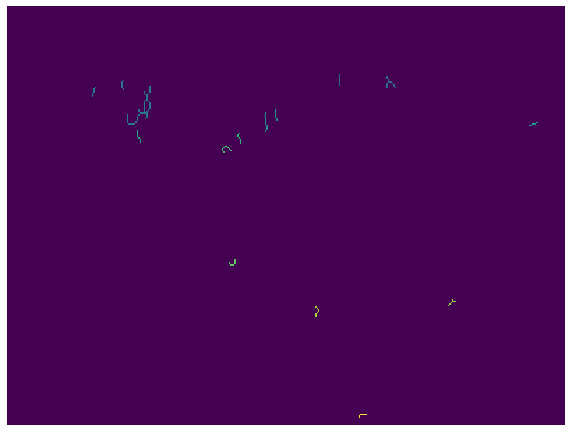

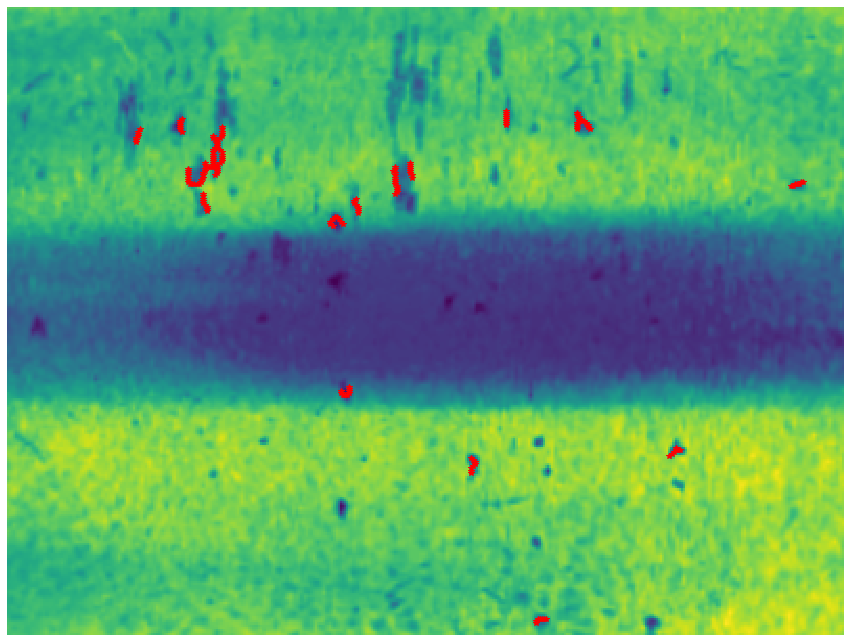

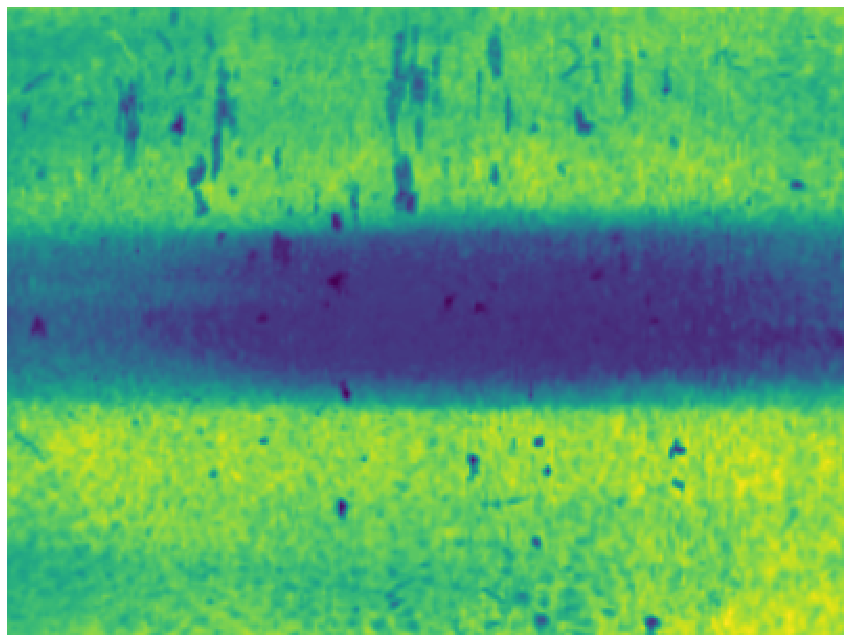

In [13]:
show_img(interactive_area.result)
points = get_points(interactive_area.result, min_dist=0)
overlay_points(img, points)
show_img(img, size=(15,15))